In [40]:
#!pip install textblob

In [381]:
from tweepy import OAuthHandler
#from tweepy.streaming import StreamListener
import tweepy
import json
import pandas as pd
import csv
import re
#from textblob import TextBlob
import string
#import preprocessor as p
import os
import time
#from twarc import expansions

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, recall_score,precision_score, confusion_matrix, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import textblob
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
from nltk.stem.porter import PorterStemmer 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet


import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


In [384]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\milad\AppData\Roaming\nltk_data...


True

In [5]:
tweets_raw = pd.read_csv('tweets.csv')
tweets_raw.isna().sum()

id              0
text            0
withheld    10177
dtype: int64

In [14]:
nltk.download("vader_lexicon")

tweets_raw = pd.read_csv('tweets.csv')
tweets_raw.drop(columns=['id','withheld'], axis=1, inplace=True)
tweets_raw.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\milad\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,text
0,Elon Musk took over Twitter. If anyone doesn't...
1,Why is this Twitter buyout a good thing again?...
2,Elon Musk’s Twitter layoffs are starting https...
3,"Elon Musk is shocked\n\n@AntonioIvanchev,@tsek..."
4,«An email went out to the company’s employees ...


In [15]:
sentiments = SentimentIntensityAnalyzer()
tweets_raw["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in tweets_raw["text"]]
tweets_raw["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in tweets_raw["text"]]
tweets_raw["Neutral"] = [sentiments.polarity_scores(i)["neu"] for i in tweets_raw["text"]]
tweets_raw['Compound'] = [sentiments.polarity_scores(i)["compound"] for i in tweets_raw["text"]]
tweets_raw.head()

,text,Positive,Negative,Neutral,Compound
0,Elon Musk took over Twitter. If anyone doesn't...,0.00,0.000,1.000,0.0000
1,Why is this Twitter buyout a good thing again?...,0.18,0.000,0.820,0.6199
2,Elon Musk’s Twitter layoffs are starting https...,0.00,0.000,1.000,0.0000
3,"Elon Musk is shocked\n\n@AntonioIvanchev,@tsek...",0.00,0.315,0.685,-0.3182
4,«An email went out to the company’s employees ...,0.00,0.050,0.950,-0.2732


In [16]:
score = tweets_raw["Compound"].values
sentiment = []
for i in score:
    if i >= 0.05 :
        sentiment.append('Positive')
    elif i <= -0.05 :
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')
tweets_raw["Sentiment"] = sentiment
tweets_raw.head()

,text,Positive,Negative,Neutral,Compound,Sentiment
0,Elon Musk took over Twitter. If anyone doesn't...,0.00,0.000,1.000,0.0000,Neutral
1,Why is this Twitter buyout a good thing again?...,0.18,0.000,0.820,0.6199,Positive
2,Elon Musk’s Twitter layoffs are starting https...,0.00,0.000,1.000,0.0000,Neutral
3,"Elon Musk is shocked\n\n@AntonioIvanchev,@tsek...",0.00,0.315,0.685,-0.3182,Negative
4,«An email went out to the company’s employees ...,0.00,0.050,0.950,-0.2732,Negative


In [95]:
tweets_raw = tweets_raw[['text','Sentiment']]
tweets_raw.head()

,text,Sentiment
0,Elon Musk took over Twitter. If anyone doesn't...,Neutral
1,Why is this Twitter buyout a good thing again?...,Positive
2,Elon Musk’s Twitter layoffs are starting https...,Neutral
3,"Elon Musk is shocked\n\n@AntonioIvanchev,@tsek...",Negative
4,«An email went out to the company’s employees ...,Negative


In [97]:
tweets_raw['Sentiment'].value_counts()

Neutral     3958
Negative    3596
Positive    2825
Name: Sentiment, dtype: int64

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

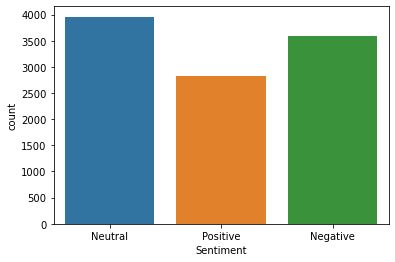

In [99]:
sns.countplot(tweets_raw['Sentiment'])

In [106]:
X=tweets_raw.text
y=tweets_raw.Sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [107]:
cv_dict = {}
def reportcrossval(model, model_name, X, Y):
    cv_mean = cross_val_score(model, X, Y).mean()
    cv_dict[model_name] = cv_mean
    print(f"The cv mean of {model_name} is {cv_mean}")

In [108]:
pipe_dummy = Pipeline([('dummy', DummyClassifier(strategy='most_frequent'))], verbose=True)

In [109]:
reportcrossval(pipe_dummy, 'Dummy', X_train, y_train)

[Pipeline] ............. (step 1 of 1) Processing dummy, total=   0.0s
[Pipeline] ............. (step 1 of 1) Processing dummy, total=   0.0s
[Pipeline] ............. (step 1 of 1) Processing dummy, total=   0.0s
[Pipeline] ............. (step 1 of 1) Processing dummy, total=   0.0s
[Pipeline] ............. (step 1 of 1) Processing dummy, total=   0.0s
The cv mean of Dummy is 0.37709262093527635


# pre-processing

In [178]:
Stop_Words = stopwords.words('english')
Stop_Words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [391]:
import numpy as np

def Cleaning_tweets(df):
    '''
    This function will Clean the given dataframe from any URL's, Mentions, Hashtags, Punctuations, Numbers,etc.
    and also lemmitize the words and returns a dataframe with cleaned tweet as a new column.
    
    '''  
    stemmer = PorterStemmer()
#    lemmatizer = WordNetLemmatizer()
    def clean_tweet(tweet):
        if type(tweet) == np.float:
            return ""
        temp = tweet.lower() # lower case the text
        temp = re.sub("'", "", temp) # to avoid removing contractions in english
        temp = re.sub("@[A-Za-z0-9_]+","", temp) # removes mentions
#        temp = re.sub("#[A-Za-z0-9_]+","", temp) # removes hashtags
        temp = re.sub(r"@(\w+)", ' ', temp, flags=re.MULTILINE)
        temp = re.sub(r'http\S+', '', temp) # removes URL's
        temp = re.sub('[()!?]', ' ', temp) # removes special charecters
        temp = re.sub('\[.*?\]',' ', temp) # further removes special charecters
        temp = re.sub("[^a-z0-9]"," ", temp)
        temp = temp.split() # splitting the words
        temp = [stemmer.stem(w) for w in temp if not w in Stop_Words] # Removes the stop words and Stemming
#        temp = [lemmatizer.lemmatize(w) for w in temp if not w in Stop_Words] # Removes the stop words and Lemming
        temp = " ".join(word for word in temp) # join all words together
        return temp
    results = [clean_tweet(tw) for tw in list(df.text)] # iterete over each tweet and clean it based on above function
    df['Cleaned_Text'] = results
    return df 

In [392]:
Cleaning_tweets(tweets_raw)

,text,Sentiment,cleaned Text,Cleaned Text,Cleaned_Text
0,Elon Musk took over Twitter. If anyone doesn't...,Neutral,elon musk took twitter anyon doesnt want leav ...,elon musk took twitter anyon doesnt want leav ...,elon musk took twitter anyon doesnt want leav ...
1,Why is this Twitter buyout a good thing again?...,Positive,twitter buyout good thing also elon musk alway...,twitter buyout good thing also elon musk alway...,twitter buyout good thing also elon musk alway...
2,Elon Musk’s Twitter layoffs are starting https...,Neutral,elon musk twitter layoff start,elon musk twitter layoff start,elon musk twitter layoff start
3,"Elon Musk is shocked\n\n@AntonioIvanchev,@tsek...",Negative,elon musk shock,elon musk shock,elon musk shock
4,«An email went out to the company’s employees ...,Negative,email went compani employe late thursday notif...,email went compani employe late thursday notif...,email went compani employe late thursday notif...
...,...,...,...,...,...
10374,Elon 'Dogefather' Musk Reportedly Tells Twitte...,Neutral,elon dogefath musk reportedli tell twitter pau...,elon dogefath musk reportedli tell twitter pau...,elon dogefath musk reportedli tell twitter pau...
10375,@Realtalk2022 @DDayCobra Elon Musk when he los...,Negative,elon musk lose money buy twitter tri get,elon musk lose money buy twitter tri get,elon musk lose money buy twitter tri get
10376,War of tweets erupts between Rep. Ocasio-Corte...,Negative,war tweet erupt rep ocasio cortez elon musk fe...,war tweet erupt rep ocasio cortez elon musk fe...,war tweet erupt rep ocasio cortez elon musk fe...
10377,“He [Elon Musk] said he would continue consult...,Negative,said would continu consult peopl color religi ...,said would continu consult peopl color religi ...,said would continu consult peopl color religi ...


In [393]:
tweets_raw.Cleaned_Text.iloc[4]

'email went compani employe late thursday notifi employe plan cut job inform 9 pacif time friday worker would receiv email subject line role twitter twitter chieftwit'

In [394]:
tweets_raw.text.iloc[4]

'«An email went out to the company’s employees late Thursday notifying employees of plans to cut jobs, informing them that by 9 a.m. Pacific time Friday, workers would receive an email with the subject line: “Your Role at Twitter.”» #Twitter #ChiefTwit  https://t.co/ypfkN5mHjS'

In [395]:
X=tweets_raw.Cleaned_Text
y=tweets_raw.Sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [213]:
def display_cross_validation_results(cross_val,model_name):
    '''
    Incoporate cross validation results into a pandas dataframe and display validation scores
    '''
    
    cross_val_results = pd.DataFrame(cross_val)
    
    accuracy = cross_val_results['mean_test_accuracy'][0]
    recall = cross_val_results['mean_test_recall'][0]
    precision = cross_val_results['mean_test_precision'][0]
    
    print('Validation','='*60)
    print(f'Validation results for {model_name}:')
    print(f'Accuracy: {accuracy}')
    print(f'Recall: {recall}')
    print(f'Precision: {precision}\n')

In [293]:
def display_prediction_results(prediction, actuall, model_name):
    '''
    Get predictions for X_test samples and display scores
    '''
    
    accuracy = accuracy_score(actuall,prediction)
    recall = recall_score(actuall, prediction, average = 'micro')
    precision = precision_score(actuall, prediction, average = 'micro')
#    roc_auc_score = roc_auc_score(actuall, prediction,  average = 'micro')

    print('='*60)
    print(f'Predictions for: {model_name}')
    print(f'Accuracy: {accuracy}')
    print(f'Recall: {recall}')
    print(f'Precision: {precision}')
#    print(f'Roc_AUC Score: {roc_auc_score}\n')

In [234]:
def display_confusion_matrix_v2(actuall_y,predicted_y,model_name):
    conf_matrix = confusion_matrix(y_true=actuall_y, y_pred=predicted_y)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
    plt.xlabel('Predictions', fontsize=14)
    plt.ylabel('Actuals', fontsize=14)
    plt.title(f'Confusion Matrix for {model_name}');
    save_image_as = 'confusion_matrix_' + '_'.join(model_name.split()) + ': ' 
    fig.savefig(save_image_as)
    

In [235]:
def display_confusion_matrix(model, X, y, model_name):
    print(f'Confusion Matrix for Model: {model_name}')
    plot_confusion_matrix(model,X,y)
    print('='*80)
    

# TF_IDF Vectorizer

In [397]:
# MultinomialNB
# Use pipes to TF_IDF Vectorize X_train and then train MultinomialNB

start = time.time()

TF_mnb_pipe = Pipeline([('tfidfvect',TfidfVectorizer()), 
                 ('mnb', MultinomialNB())])

grid_accuracy = make_scorer(accuracy_score)
grid_recall_micro = make_scorer(recall_score, average = 'micro')
grid_precision_micro = make_scorer(precision_score, average = 'micro')

TF_mnb_params = {'tfidfvect__input' : ['content'],
                 'tfidfvect__ngram_range': [(1, 1), (1, 2), (1, 3)],
                 'mnb__alpha' : [1.0]}

TF_mnb_model_grid = GridSearchCV(estimator = TF_mnb_pipe, param_grid = TF_mnb_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')

TF_mnb_model_grid.fit(X_train,y_train)
display(TF_mnb_model_grid.best_score_)
display(TF_mnb_model_grid.best_params_)
#end = time.time()
#print(f'Training time: {end-start}')

0.742141473781943

{'mnb__alpha': 1.0,
 'tfidfvect__input': 'content',
 'tfidfvect__ngram_range': (1, 1)}

In [364]:
# Display cross validation results, make prediction for X_test 
# diplay results.  Use respective functions.

model_name = 'MultinomialNB with TF-IDF Vectorize'

display_cross_validation_results(TF_mnb_model_grid.cv_results_,model_name)

y_hat_TF_MNB = TF_mnb_model_grid.predict(X_test)

display_prediction_results(y_hat_TF_MNB, y_test,model_name)


Validation ============================================================
Validation results for MultinomialNB with TF-IDF Vectorize:
Accuracy: 0.7405749185785889
Recall: 0.7405749185785889
Precision: 0.7405749185785889

Predictions for: MultinomialNB with TF-IDF Vectorize
Accuracy: 0.7577071290944123
Recall: 0.7577071290944123
Precision: 0.7577071290944123


Confusion Matrix for Model: MultinomialNB with TF-IDF Vectorize


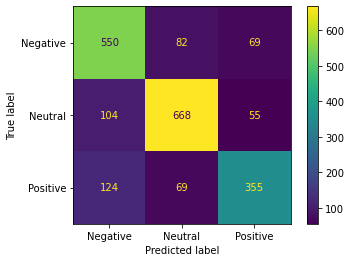

In [250]:
display_confusion_matrix(TF_mnb_model_grid, X_test,
                         y_test,model_name)

In [258]:
# LogisticRegression
# Use pipes to TF_IDF Vectorize X_train and then train LogisticRegression

TF_LR_pipe = Pipeline([('tfidfvect',TfidfVectorizer()), 
                 ('lr', LogisticRegression())])

grid_accuracy = make_scorer(accuracy_score)
grid_recall_micro = make_scorer(recall_score, average = 'micro')
grid_precision_micro = make_scorer(precision_score, average = 'micro')

TF_LR_params = {'tfidfvect__input' : ['content'],
                 'tfidfvect__ngram_range': [(1, 1), (1, 2)],
                 'lr__penalty' : ['l1','l2'],
                'lr__C' : [1.0, 100],  # tried 1 and 1000
                'lr__class_weight' : [None],  # tried None and 'balanced'
                'lr__solver' : ['liblinear','lbfgs','newton-cg'], # tried 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'
                'lr__max_iter' : [100,1000]} # treid 100,1000 and 10000

TF_LR_model_grid = GridSearchCV(estimator = TF_LR_pipe, param_grid = TF_LR_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')

TF_LR_model_grid.fit(X_train,y_train)
display(TF_LR_model_grid.best_score_)
display(TF_LR_model_grid.best_params_)
#end = time.time()
#print(f'Training time: {end-start}')

0.8430682634209324

{'lr__C': 100,
 'lr__class_weight': None,
 'lr__max_iter': 100,
 'lr__penalty': 'l1',
 'lr__solver': 'liblinear',
 'tfidfvect__input': 'content',
 'tfidfvect__ngram_range': (1, 2)}

In [306]:
# Display cross validation results, make prediction for X_test 
# diplay results.  Use respective functions.

model_name = 'Logistic Regression with TF-IDF Vectorize'

display_cross_validation_results(TF_LR_model_grid.cv_results_,model_name)

y_hat_TF_LR = TF_LR_model_grid.predict(X_test)

display_prediction_results(y_hat_TF_LR, y_test,model_name)


Validation ============================================================
Validation results for Logistic Regression with TF-IDF Vectorize:
Accuracy: 0.8022384541174935
Recall: 0.8022384541174935
Precision: 0.8022384541174935

Predictions for: Logistic Regression with TF-IDF Vectorize
Accuracy: 0.861271676300578
Recall: 0.861271676300578
Precision: 0.861271676300578


Confusion Matrix for Model: Logistic Regression with TF-IDF Vectorize


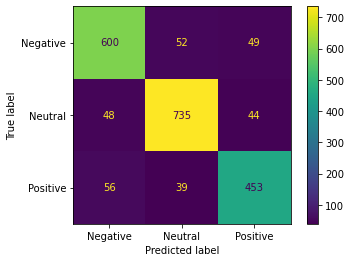

In [296]:
display_confusion_matrix(TF_LR_model_grid, X_test,
                         y_test,model_name)

# Count Vectorizer

In [361]:
# MultinomialNB
# Use pipes to Count Vectorize X_train and then train MultinomialNB

start = time.time()

CT_mnb_pipe = Pipeline([('countvect',CountVectorizer()), 
                 ('mnb', MultinomialNB())])

grid_accuracy = make_scorer(accuracy_score)
grid_recall_micro = make_scorer(recall_score, average = 'micro')
grid_precision_micro = make_scorer(precision_score, average = 'micro')

CT_mnb_params = {'countvect__input' : ['content'],
                 'countvect__ngram_range': [(1, 1), (1, 2), (1, 3)],
                 'mnb__alpha' : [1.0]}

CT_mnb_model_grid = GridSearchCV(estimator = CT_mnb_pipe, param_grid = CT_mnb_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')

CT_mnb_model_grid.fit(X_train,yy_train)
display(CT_mnb_model_grid.best_score_)
display(CT_mnb_model_grid.best_params_)
#end = time.time()
#print(f'Training time: {end-start}')

0.7467176834973851

{'countvect__input': 'content',
 'countvect__ngram_range': (1, 2),
 'mnb__alpha': 1.0}

In [362]:
# Display cross validation results, make prediction for X_test 
# diplay results.  Use respective functions.

model_name = 'MultinomialNB with Count Vectorize'

display_cross_validation_results(CT_mnb_model_grid.cv_results_,model_name)

y_hat_CT_MNB = CT_mnb_model_grid.predict(X_test)

display_prediction_results(y_hat_CT_MNB, y_test,model_name)

Validation ============================================================
Validation results for MultinomialNB with Count Vectorize:
Accuracy: 0.7364802013593205
Recall: 0.7364802013593205
Precision: 0.7364802013593205

Predictions for: MultinomialNB with Count Vectorize
Accuracy: 0.766859344894027
Recall: 0.766859344894027
Precision: 0.766859344894027


Confusion Matrix for Model: MultinomialNB with Count Vectorize


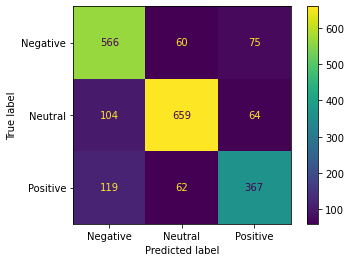

In [304]:
display_confusion_matrix(CT_mnb_model_grid, X_test,
                         y_test,model_name)

In [309]:
# LogisticRegression
# Use pipes to TF_IDF Vectorize X_train and then train LogisticRegression

CT_LR_pipe = Pipeline([('countvect',CountVectorizer()), 
                 ('lr', LogisticRegression())])

grid_accuracy = make_scorer(accuracy_score)
grid_recall_micro = make_scorer(recall_score, average = 'micro')
grid_precision_micro = make_scorer(precision_score, average = 'micro')

CT_LR_params = {'countvect__input' : ['content'],
                 'countvect__ngram_range': [(1, 1), (1, 2)],
                 'lr__penalty' : ['l1','l2'],
                'lr__C' : [1.0, 100],  # tried 1 and 1000
                'lr__class_weight' : ['balanced'],  # tried None and 'balanced'
                'lr__solver' : ['liblinear','lbfgs','newton-cg'], # tried 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'
                'lr__max_iter' : [100,1000]} # treid 100,1000 and 10000

CT_LR_model_grid = GridSearchCV(estimator = CT_LR_pipe, param_grid = CT_LR_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')

CT_LR_model_grid.fit(X_train,y_train)
display(CT_LR_model_grid.best_score_)
display(CT_LR_model_grid.best_params_)

0.8416216823948414

{'countvect__input': 'content',
 'countvect__ngram_range': (1, 2),
 'lr__C': 100,
 'lr__class_weight': 'balanced',
 'lr__max_iter': 100,
 'lr__penalty': 'l1',
 'lr__solver': 'liblinear'}

In [310]:
# Display cross validation results, make prediction for X_test 
# diplay results.  Use respective functions.

model_name = 'Logistic Regression with Count Vectorize'

display_cross_validation_results(CT_mnb_model_grid.cv_results_,model_name)

y_hat_CT_LR = CT_LR_model_grid.predict(X_test)

display_prediction_results(y_hat_CT_LR, y_test,model_name)

Validation ============================================================
Validation results for Logistic Regression with Count Vectorize:
Accuracy: 0.7364802013593205
Recall: 0.7364802013593205
Precision: 0.7364802013593205

Predictions for: Logistic Regression with Count Vectorize
Accuracy: 0.8636801541425819
Recall: 0.8636801541425819
Precision: 0.8636801541425819


Confusion Matrix for Model: Logistic Regression with Count Vectorize


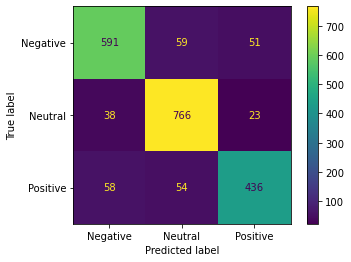

In [311]:
display_confusion_matrix(CT_LR_model_grid, X_test,
                         y_test,model_name)

In [354]:
b=[]
a=tweets_raw.text.iloc[3]
b.append(a)
display(b)
display(len(a))

['Elon Musk is shocked\n\n@AntonioIvanchev,@tseki_is,@Ed_Cypress,@HectagonFinance,@arcade5io,@saiful_ghazi93,@UrielPiquera,@BoredNFT4\n\nhttps://t.co/jOuAX9oSm9']

154

In [355]:
vectorizer = CountVectorizer(stop_words=Stop_Words)
XXXX = vectorizer.fit_transform(b)
vectorizer.get_feature_names()

['antonioivanchev',
 'arcade5io',
 'borednft4',
 'co',
 'ed_cypress',
 'elon',
 'hectagonfinance',
 'https',
 'jouax9osm9',
 'musk',
 'saiful_ghazi93',
 'shocked',
 'tseki_is',
 'urielpiquera']

In [339]:
TF_vectorizer = TfidfVectorizer(stop_words=Stop_Words)
XXXX = TF_vectorizer.fit_transform(b)
TF_vectorizer.get_feature_names()

['chieftwit',
 'co',
 'company',
 'cut',
 'email',
 'employees',
 'friday',
 'https',
 'informing',
 'jobs',
 'late',
 'line',
 'notifying',
 'pacific',
 'plans',
 'receive',
 'role',
 'subject',
 'thursday',
 'time',
 'twitter',
 'went',
 'workers',
 'would',
 'ypfkn5mhjs']

In [356]:
TW_Tok = TweetTokenizer(strip_handles=True)
XXXX = TW_Tok.tokenize(a)
XXXXX = vectorizer.fit_transform(XXXX)
vectorizer.get_feature_names()


['co', 'elon', 'https', 'jouax9osm9', 'musk', 'shocked']